In [1]:
import os
from google.colab import drive
drive.mount("/content/drive")
os.chdir("/content/drive/MyDrive/ECE590_FinalProject")
!pwd

Mounted at /content/drive
/content/drive/MyDrive/ECE590_FinalProject


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Apr  3 22:51:18 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    30W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import time
import datetime
import warnings
import os, random
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from models import CNN
from models import RNN
from models import AUTOENCODER
from attacks import gradient_wrt_data
from attacks import FGSM_Linf_attack
from attacks import FGSM_L2_attack
from utilities import *


from torchsummary import summary
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from torch.utils.data import DataLoader, TensorDataset
from scipy.interpolate import make_interp_spline

In [5]:
seed = 5
np.random.seed(seed)
torch.manual_seed(seed)

# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"]="2"  # specify which GPU(s) to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.device_count())
print("Current Device: ", device)
print(torch.cuda.get_device_name(torch.cuda.current_device()))

1
Current Device:  cuda
Tesla P100-PCIE-16GB


In [6]:
filename = "RML2016.10b.dat"
snrs, mods, X, labels = process_data(filename)

In [7]:
curr_model = "CNN"

subsample = 1
# subsample = 2
# subsample = 4
# subsample = 8

In [8]:
x_train0, x_test0, y_train, y_test, test_labels, test_idx = train_test_split(X, labels, mods, NN = curr_model)

#####################################################################
x_train = x_train0[:,:,:,::subsample]
x_test = x_test0[:,:,:,::subsample]
####################################################################

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

torch.Size([480000, 1, 2, 128])
torch.Size([120000, 1, 2, 128])
torch.Size([480000])
torch.Size([120000])


In [9]:
# curr_model = "NEW_CNN"
class NEW_CNN(nn.Module) :
    def __init__(self, input_size = 128, num_classes = 10) :
        super(NEW_CNN, self).__init__()
        self.conv_one = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 64, kernel_size = (2, 5)),
            nn.ReLU(inplace = True),
        )
        self.dropout_one = nn.Dropout(p = 0.2)

        self.conv_two = nn.Sequential(
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = (1, 4)),
            nn.ReLU(inplace = True),
        )
        self.dropout_two = nn.Dropout(p = 0.2)

        self.conv_three = nn.Sequential(
            nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = (1, 3)),
            nn.ReLU(inplace = True),
        )
        self.dropout_three = nn.Dropout(p = 0.2)

        self.conv_four = nn.Sequential(
            nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = (1, 3)),
            nn.ReLU(inplace = True),
        )
        self.dropout_four = nn.Dropout(p = 0.2)

        self.classifier = nn.Sequential(
            nn.Linear(in_features = 1 * (input_size - 11) * 256, out_features = 128),
            nn.ReLU(inplace = True),
            nn.Linear(in_features = 128, out_features = 64), 
            nn.ReLU(inplace = True), 
            nn.Linear(in_features = 64, out_features = num_classes),
        )

    def forward(self, x) :
        out = self.conv_one(x)
        out = self.dropout_one(out)
        out = self.conv_two(out)
        out = self.dropout_two(out)
        out = self.conv_three(out)
        out = self.dropout_three(out)
        out = self.conv_four(out)
        out = self.dropout_four(out)

        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

In [10]:
if curr_model == "CNN" :
    batch_size = 256    
    if subsample == 1 : 
        model = CNN(input_size = 128).to(device = device)
        model_checkpoint = "CNN_base.pt"
    if subsample == 2 :
        model = CNN(input_size = 64).to(device = device)
        model_checkpoint = "CNN_base_sub12.pt"
    if subsample == 4 :
        model = CNN(input_size = 32).to(device = device)
        model_checkpoint = "CNN_base_sub14.pt"
    if subsample == 8 :
        model = CNN(input_size = 16).to(device = device)
        model_checkpoint = "CNN_base_sub18.pt"

if curr_model == "NEW_CNN" : 
    batch_size = 256
    model = NEW_CNN(input_size = 128).to(device)
    model_checkpoint = "NEW_CNN_base.pt"

num_epochs = 100
criterion  = nn.CrossEntropyLoss()
optimizer  = optim.Adam(model.parameters(), lr = 0.001)

train_dataset = TensorDataset(x_train, y_train.type(torch.LongTensor))
test_dataset  = TensorDataset(x_test,  y_test.type(torch.LongTensor))

TrainLoader = DataLoader(train_dataset, batch_size = batch_size, 
                         shuffle = False)
TestLoader  = DataLoader(test_dataset,  batch_size = batch_size, 
                         shuffle = False)

In [11]:
##############################################################################

In [ ]:
def prune_by_percentage(layer, q = 80.0):
    # Convert the weight of "layer" to numpy array
    np_weight = layer.weight.detach().cpu().numpy()
    # Compute the q-th percentile of the abs of the converted array
    weight_abs = np.absolute(np_weight)
    qth_percentile = np.percentile(weight_abs, q)
    # Generate a binary mask same shape as weight to decide which element to prune
    binary_mask = weight_abs > qth_percentile
    # Convert mask to torch tensor and put on GPU
    mask_tensor = torch.from_numpy(binary_mask).float().to(device)
    # Multiply the weight by mask to perform pruning
    layer.weight.data = layer.weight.data * mask_tensor
    return None 

In [ ]:
# Model Compression - Prune Weights Here
arr_q = np.linspace(0.0, 90.0, num = 10)
pruned_acc = np.zeros(10)
finetuned_acc = np.zeros(6)

for i in range(arr_q.shape[0]) :
    net = CNN()
    finetuned_net = CNN()

    net.load_state_dict(torch.load("CNN_base.pt"))
    if arr_q[i] == 40.0 :
        finetuned_net.load_state_dict(torch.load("CNN_prune40_finetune.pt"))
    if arr_q[i] == 50.0 :
        finetuned_net.load_state_dict(torch.load("CNN_prune50_finetune.pt"))
    if arr_q[i] == 60.0 :
        finetuned_net.load_state_dict(torch.load("CNN_prune60_finetune.pt"))
    if arr_q[i] == 70.0 :
        finetuned_net.load_state_dict(torch.load("CNN_prune70_finetune.pt"))
    if arr_q[i] == 80.0 :
        finetuned_net.load_state_dict(torch.load("CNN_prune80_finetune.pt"))
    if arr_q[i] == 90.0 :
        finetuned_net.load_state_dict(torch.load("CNN_prune90_finetune.pt"))
    
    net = net.to(device)
    finetuned_net = finetuned_net.to(device) 
    zeros_sum = 0 
    total_sum = 0 
    for name, layer in net.named_modules() :
        if (isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear)) and "id_mapping" not in name :
            prune_by_percentage(layer, q = arr_q[i])
            np_weight = layer.weight.detach().cpu().numpy()
            zeros = np_weight.size - np.count_nonzero(np_weight) 
            total = np_weight.size
            zeros_sum += zeros 
            total_sum += total 
            # print("Sparsity of "+name+": "+str(zeros/total))
    print("Total sparsity = %.3f" % float(zeros_sum / total_sum)) 

    cnn_acc, cnn_loss, y_preds = evaluate_model(net, TestLoader, device)
    # y_test_np = y_test.cpu().numpy()
    print("Accuracy after Model Compression = %.4f" % cnn_acc)
    pruned_acc[i] = cnn_acc 

    if arr_q[i] >= 40.0 :
        cnn_acc2, cnn_loss2, y_preds2 = evaluate_model(finetuned_net, TestLoader, device) 
        print("Accuracy after Model Finetuning = %.4f" % cnn_acc2)
        finetuned_acc[i-4] = cnn_acc2 
print(pruned_acc)
print(finetuned_acc)

Total sparsity = 0.000
Accuracy after Model Compression = 0.9078
Total sparsity = 0.100
Accuracy after Model Compression = 0.9072
Total sparsity = 0.200
Accuracy after Model Compression = 0.9071
Total sparsity = 0.300
Accuracy after Model Compression = 0.9053
Total sparsity = 0.400
Accuracy after Model Compression = 0.8988
Accuracy after Model Finetuning = 0.9091
Total sparsity = 0.500
Accuracy after Model Compression = 0.8835
Accuracy after Model Finetuning = 0.9088
Total sparsity = 0.600
Accuracy after Model Compression = 0.8430
Accuracy after Model Finetuning = 0.9086
Total sparsity = 0.700
Accuracy after Model Compression = 0.6538
Accuracy after Model Finetuning = 0.9088
Total sparsity = 0.800
Accuracy after Model Compression = 0.2960
Accuracy after Model Finetuning = 0.9071
Total sparsity = 0.900
Accuracy after Model Compression = 0.1558
Accuracy after Model Finetuning = 0.8517
[0.90775833 0.90718333 0.907125   0.90529167 0.89883333 0.88354167
 0.84305    0.65376667 0.29605    0.1

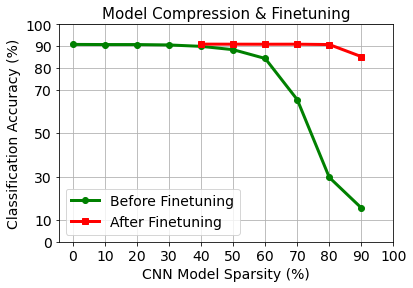

In [ ]:
figure, axis = plt.subplots()
x_pruned = np.linspace(0.0, 90.0, num = 10).astype(int)
x_finetuned = np.linspace(40.0, 90.0, num = 6).astype(int)
axis.plot(x_pruned, 100 * pruned_acc, "g-o", label = "Before Finetuning", linewidth = 3)
axis.plot(x_finetuned, 100 * finetuned_acc, "r-s", label = "After Finetuning", linewidth = 3)
axis.set_xlabel("CNN Model Sparsity (%)", fontsize = 14)
axis.set_ylabel("Classification Accuracy (%)", fontsize = 14)
axis.set_title("Model Compression & Finetuning", fontsize = 15)
axis.grid()
figure.set_size_inches(6, 4)
plt.xticks(np.linspace(0, 100, num = 11).astype(int), fontsize = 14)
plt.yticks(np.array([0, 10, 30, 50, 70, 80, 90, 100]), fontsize = 14)
plt.legend(loc = "lower left", fontsize = 14)
plt.show()

In [ ]:
# from torchsummary import summary
# summary(net, input_size = (1, 2, 128))

In [ ]:
def finetune_after_prune(net, trainloader, criterion, optimizer, prune=True):
    """
    Finetune the pruned model for a single epoch
    Make sure pruned weights are kept as zero
    """
    # Build a dictionary for the nonzero weights
    weight_mask = {}
    for name,layer in net.named_modules():
        if (isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear)) and 'id_mapping' not in name:
            # Your code here: generate a mask in GPU torch tensor to have 1 for nonzero element and 0 for zero element
            weight_mask[name] = layer.weight.data != 0.0
            #print(weight_mask[name])   


    global_steps = 0
    train_loss = 0
    correct = 0
    total = 0
    start = time.time()
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        if prune:
            for name,layer in net.named_modules():
                if (isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear)) and 'id_mapping' not in name:
                    # Your code here: Use weight_mask to make sure zero elements remains zero
                    layer.weight.data = layer.weight.data * weight_mask[name]
                    #print(layer.weight.data)
                    
        
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        global_steps += 1

        if global_steps % 500 == 0:
            end = time.time()
            num_examples_per_second = 500 * batch_size / (end - start)
            print("[Step=%d]\tLoss=%.4f\tacc=%.4f\t%.1f examples/second"
                 % (global_steps, train_loss / (batch_idx + 1), (correct / total), num_examples_per_second))
            start = time.time()
    return None 

In [ ]:
# Prune model for finetuning
net = CNN()
net.load_state_dict(torch.load("CNN_base.pt"))
net = net.to(device)
#finetune_q = 40.0 
#finetune_q = 50.0 
#finetune_q = 60.0 
#finetune_q = 70.0 
#finetune_q = 80.0 
finetune_q = 90.0 
for name, layer in net.named_modules() :
    if (isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear)) and "id_mapping" not in name :
        prune_by_percentage(layer, q = finetune_q) 

In [ ]:
# Model finetuning
best_acc = 0
criterion  = nn.CrossEntropyLoss()
optimizer  = optim.Adam(net.parameters(), lr = 0.001)
finetune_epochs = 10
if finetune_q == 70.0 :
    finetune_epochs = 20
if finetune_q >= 80.0 :
    finetune_epochs = 30
for epoch in range(finetune_epochs): 
    print('\nEpoch: %d' % (epoch+1))
    print("Current Pruning Percentage is %.2f" % finetune_q)
    net.train()
    finetune_after_prune(net, TrainLoader, criterion, optimizer, prune = True)
    #Start the testing code.
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(TestLoader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    num_val_steps = len(TestLoader)
    val_acc = correct / total
    print("Test Loss=%.4f, Test acc=%.4f" % (test_loss / (num_val_steps), val_acc))

    if val_acc > best_acc:
        best_acc = val_acc
        print("Saving...")
        if finetune_q == 40.0 :
            torch.save(net.state_dict(), "CNN_prune40_finetune.pt")
        if finetune_q == 50.0 :
            torch.save(net.state_dict(), "CNN_prune50_finetune.pt")
        if finetune_q == 60.0 :
            torch.save(net.state_dict(), "CNN_prune60_finetune.pt")
        if finetune_q == 70.0 :
            torch.save(net.state_dict(), "CNN_prune70_finetune.pt")
        if finetune_q == 80.0 :
            torch.save(net.state_dict(), "CNN_prune80_finetune.pt")
        if finetune_q == 90.0 :
            torch.save(net.state_dict(), "CNN_prune90_finetune.pt")


Epoch: 1
Current Pruning Percentage is 90.00
[Step=500]	Loss=1.3156	acc=0.5391	19243.3 examples/second
[Step=1000]	Loss=1.0734	acc=0.6033	19309.2 examples/second
[Step=1500]	Loss=0.9439	acc=0.6368	19572.6 examples/second
Test Loss=0.5354, Test acc=0.7484
Saving...

Epoch: 2
Current Pruning Percentage is 90.00
[Step=500]	Loss=0.5424	acc=0.7350	19312.2 examples/second
[Step=1000]	Loss=0.5275	acc=0.7408	19320.2 examples/second
[Step=1500]	Loss=0.5137	acc=0.7463	19604.3 examples/second
Test Loss=0.4459, Test acc=0.7795
Saving...

Epoch: 3
Current Pruning Percentage is 90.00
[Step=500]	Loss=0.4683	acc=0.7621	19349.5 examples/second
[Step=1000]	Loss=0.4617	acc=0.7650	19359.5 examples/second
[Step=1500]	Loss=0.4564	acc=0.7669	19626.4 examples/second
Test Loss=0.4300, Test acc=0.7825
Saving...

Epoch: 4
Current Pruning Percentage is 90.00
[Step=500]	Loss=0.4340	acc=0.7729	19585.5 examples/second
[Step=1000]	Loss=0.4321	acc=0.7735	19337.6 examples/second
[Step=1500]	Loss=0.4275	acc=0.7754	1959

### Baseline Model Training

In [ ]:
num_epochs   = 100
best_val_acc = 0.
criterion    = nn.CrossEntropyLoss()
optimizer    = optim.Adam(model.parameters(), lr = 0.001)

for epoch in range(num_epochs) :
    model.train()
    train_epoch_loss = 0.
    train_epoch_acc  = 0.
    for batch_idx, (data, labels) in enumerate(TrainLoader) :
        data   = data.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(data)
        loss    = criterion(outputs, labels)
        acc     = evaluate_accuracy(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_epoch_loss += loss.item()
        train_epoch_acc  += acc.item()
    
    with torch.no_grad() :
        model.eval()
        val_epoch_loss = 0.
        val_epoch_acc  = 0.
        
        for X_val_batch, y_val_batch in TestLoader :
            X_val_batch = X_val_batch.to(device)
            y_val_batch = y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
            
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc  = evaluate_accuracy(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc  += val_acc.item()
    
    avg_train_loss = float(train_epoch_loss) / len(TrainLoader)
    avg_train_acc  = float(train_epoch_acc) / len(TrainLoader)
    avg_val_loss   = float(val_epoch_loss) / len(TestLoader)
    avg_val_acc    = float(val_epoch_acc) / len(TestLoader)
    
    print(f'Epoch {epoch+1}: | Train Acc: {avg_train_acc:.3f} | Test Acc: {avg_val_acc:.3f}')
    
    if avg_val_acc > best_val_acc :
        print("Saving Model Checkpoint......")
        best_val_acc = avg_val_acc
        torch.save(model.state_dict(), model_checkpoint)

print("Training Complete!")

In [ ]:
##########################################################################

### Baseline Model Testing

In [ ]:
cnn_net1 = CNN()
cnn_net2 = CNN(input_size=64)
cnn_net4 = CNN(input_size=32)
cnn_net8 = CNN(input_size=16)
cnn_netNEW = NEW_CNN(input_size=128)
cnn_net1.load_state_dict(torch.load("CNN_base.pt"))
cnn_net2.load_state_dict(torch.load("CNN_base_sub12.pt"))
cnn_net4.load_state_dict(torch.load("CNN_base_sub14.pt"))
cnn_net8.load_state_dict(torch.load("CNN_base_sub18.pt"))
cnn_netNEW.load_state_dict(torch.load("NEW_CNN_base.pt"))
cnn_net1 = cnn_net1.to(device)
cnn_net2 = cnn_net2.to(device)
cnn_net4 = cnn_net4.to(device)
cnn_net8 = cnn_net8.to(device)
cnn_netNEW = cnn_netNEW.to(device)

In [ ]:
cnn_acc1, cnn_loss1, y_preds1 = evaluate_model(cnn_net1, TestLoader, device)
y_test_np = y_test.cpu().numpy()
print("CNN_base Accuracy = %.4f" % cnn_acc1)

cnn_acc_new, cnn_loss_new, y_preds_new = evaluate_model(cnn_netNEW, TestLoader, device) 
print("NEW CNN Accuracy = %.4f" % cnn_acc_new)  

CNN_base Accuracy = 0.9078
NEW CNN Accuracy = 0.9001


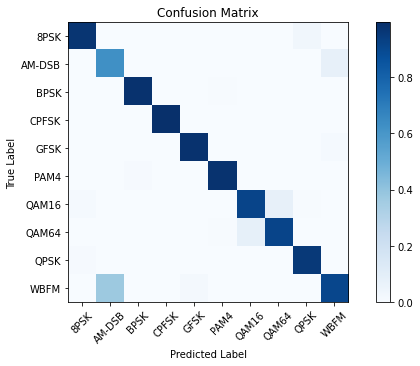

In [ ]:
plot_confusion_matrix(y_tests = y_test.cpu().numpy(), 
                      y_preds = y_preds1, mods = mods)

In [ ]:
def predict_wrt_snr (model, y, device) :
    with torch.no_grad() :
        y = y.to(device = device)
        prediction = model(y)
        _, predicted_class = torch.max(prediction, dim = 1)
        return predicted_class.cpu().numpy()

def plot_snr_accuracy (model, x_test, labels,
                       test_labels, test_idx, snrs, mods, device) :
    acc = {}
    for snr in snrs :
        test_SNRs = list(map(lambda x: labels[x][1], test_idx))
        test_X_i = x_test[np.where(np.array(test_SNRs) == snr)]
        test_Y_i = test_labels[np.where(np.array(test_SNRs) == snr)]
        test_Y_i_hat = predict_wrt_snr(model, test_X_i, device)
        cm = confusion_matrix(test_Y_i, test_Y_i_hat)
        cofnorm = np.zeros([len(mods), len(mods)])
        for i in range(len(mods)) :
            cofnorm[i, :] = cm[i, :] / np.sum(cm[i, :])
        cor = np.sum(np.diag(cm))
        ncor = np.sum(cm) - cor
        acc[snr] = 1.0 * cor / (cor + ncor)

    # plt.plot(snrs, list(map(lambda x: 100 * acc[x], snrs)))
    # plt.grid()
    # plt.xticks(np.arange(0, 22, 2))
    # plt.xlabel("Signal to Noise Ratio (SNR)")
    # plt.ylabel("Classification Accuracy (%)")
    return acc

In [ ]:
x_train2, x_test2 = x_train0[:,:,:,::2], x_test0[:,:,:,::2]
x_train4, x_test4 = x_train0[:,:,:,::4], x_test0[:,:,:,::4]
x_train8, x_test8 = x_train0[:,:,:,::8], x_test0[:,:,:,::8]
acc_dict1 = plot_snr_accuracy(cnn_net1, x_test0, labels, test_labels, test_idx, snrs, mods, device)
acc_dict2 = plot_snr_accuracy(cnn_net2, x_test2, labels, test_labels, test_idx, snrs, mods, device)
acc_dict4 = plot_snr_accuracy(cnn_net4, x_test4, labels, test_labels, test_idx, snrs, mods, device)
acc_dict8 = plot_snr_accuracy(cnn_net8, x_test8, labels, test_labels, test_idx, snrs, mods, device)

In [ ]:
print(type(snrs))
print(snrs)

<class 'numpy.ndarray'>
[ 0  2  4  6  8 10 12 14 16 18]


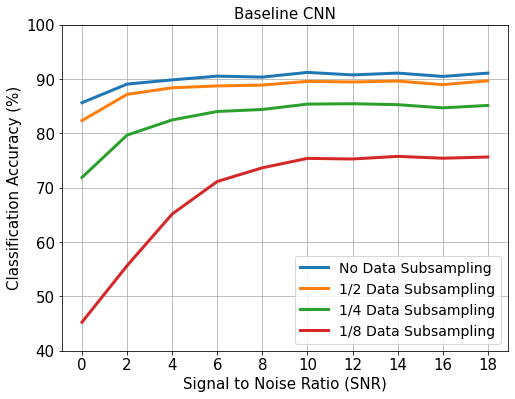

In [ ]:
figure, axis = plt.subplots()
axis.plot(snrs, list(map(lambda x: 100 * acc_dict1[x], snrs)), label = "No Data Subsampling", linewidth = 3)
axis.plot(snrs, list(map(lambda x: 100 * acc_dict2[x], snrs)), label = "1/2 Data Subsampling", linewidth = 3)
axis.plot(snrs, list(map(lambda x: 100 * acc_dict4[x], snrs)), label = "1/4 Data Subsampling", linewidth = 3)
axis.plot(snrs, list(map(lambda x: 100 * acc_dict8[x], snrs)), label = "1/8 Data Subsampling", linewidth = 3)
axis.set_xlabel("Signal to Noise Ratio (SNR)", fontsize = 15)
axis.set_ylabel("Classification Accuracy (%)", fontsize = 15)
axis.set_title("Baseline CNN", fontsize = 15)
axis.grid()
figure.set_size_inches(8, 6)
plt.xticks(snrs, fontsize = 15)
plt.yticks(np.array([40, 50, 60, 70, 80, 90, 100]), fontsize = 15)
plt.legend(loc = "lower right", fontsize = 14)
plt.show()

In [ ]:
###########################################################################

### Adversarial Attacks

In [ ]:
# Compute the gradient of the loss w.r.t. the input data
def gradient_wrt_data(model, device, data, lbl):
    dat = data.clone().detach()
    dat = dat.to(device)
    dat.requires_grad = True
    out = model(dat)
    loss = F.cross_entropy(out,lbl)
    model.zero_grad()
    loss.backward()
    data_grad = dat.grad.data
    return data_grad.data.detach()

# def FGSM_Linf_attack(model, device, dat, lbl, eps):
#     x_nat    = dat.clone().detach()
#     x_nat    = x_nat.to(device)
#     gradient = gradient_wrt_data(model, device, x_nat, lbl).to(device)
#     x_adv    = x_nat + eps * torch.sign(gradient).to(device)
#     return x_adv

In [ ]:
def PGD_attack (model, device, dat, lbl, eps, alpha, iters, rand_start = True) :
    x_nat = dat.clone().detach()
    x_nat = x_nat.to(device)
    if rand_start == True :
        x_adv = x_nat + torch.FloatTensor(x_nat.shape).uniform_(-eps, eps).to(device)
    else :
        x_adv = x_nat
     
    for i in range(0, iters) : 
        gradient = gradient_wrt_data(model, device, x_adv, lbl).to(device)
        x_adv = x_adv + alpha * torch.sign(gradient).to(device)
        x_adv = torch.clamp(x_adv + alpha * torch.sign(gradient).to(device), 
                            min = x_nat - eps, max = x_nat + eps)
    return x_adv 

In [ ]:
# EPS for PGD attack
curr_attack = "PGD"
eps_values = np.array([0.000, 0.001, 0.002, 0.003, 0.005, 0.007, 0.010, 0.020, 0.030])
pgd_acc = np.zeros(len(eps_values))
blackbox_pgd_acc = np.zeros(len(eps_values))
pgd_art_pgd_acc = np.zeros(len(eps_values))
fgsm_art_pgd_acc = np.zeros(len(eps_values))

In [ ]:
# EPS for FGSM attack
curr_attack = "FGSM_Linfinity"
eps_values = np.array([0.000, 0.001, 0.002, 0.003, 0.005, 0.007, 0.010, 0.020, 0.030])
fgsm_acc = np.zeros(len(eps_values))
blackbox_fgsm_acc = np.zeros(len(eps_values))
fgsm_art_acc = np.zeros(len(eps_values))
pgd_art_fgsm_acc = np.zeros(len(eps_values))
pgd_AT_fgsm_acc = np.zeros(len(eps_values)) 

In [ ]:
# EPS for FGM L2 attack
curr_attack = "FGSM_L2"
#eps_values = np.array([0.00, 0.01, 0.02, 0.04, 0.06, 0.08, 0.10, 0.20, 0.30, 0.40, 0.50])
eps_values = np.array([0.000, 0.001, 0.002, 0.003, 0.005, 0.007, 0.010, 0.020, 0.030])
fgm_acc = np.zeros(len(eps_values))
fgm_art_acc = np.zeros(len(eps_values))
blackbox_fgm_acc = np.zeros(len(eps_values))

In [ ]:
whitebox = CNN(input_size = 128)
blackbox = NEW_CNN(input_size = 128)

whitebox.load_state_dict(torch.load("CNN_base.pt"))
blackbox.load_state_dict(torch.load("NEW_CNN_base.pt"))

# whitebox.load_state_dict(torch.load("CNN_FGSM_ART.pt"))
# whitebox.load_state_dict(torch.load("CNN_FGML2_ART.pt"))
# whitebox.load_state_dict(torch.load("CNN_PGD_ART.pt"))
# whitebox.load_state_dict(torch.load("CNN_PGD_AdvTrain.pt"))

# whitebox.load_state_dict(torch.load("CNN_base_sub12.pt"))
# whitebox.load_state_dict(torch.load("CNN_FGSM_ART_sub12.pt"))
# whitebox.load_state_dict(torch.load("CNN_FGML2_ART_sub12.pt"))

whitebox = whitebox.to(device)
blackbox = blackbox.to(device)
whitebox.eval()
blackbox.eval()
for i in range(len(eps_values)) :
    print("Current ATK_EPS Index = " + str(i + 1))
    ATK_EPS   = eps_values[i]
    # ATK_ITERS = 10
    ATK_ITERS = 3
    # ATK_ALPHA = 1.85 * (ATK_EPS / ATK_ITERS)
    ATK_ALPHA = float(ATK_EPS / ATK_ITERS) * 0.5
    whitebox_correct = 0
    blackbox_correct = 0
    running_total    = 0
    for batch_idx, (data, labels) in enumerate(TestLoader) :
        data   = data.to(device)
        labels = labels.to(device)
        
        #################################################################
        if curr_attack == "FGSM_Linfinity" :
            # Fast Gradient Sign Method (FGSM) L-infinity Norm Attack
            adv_data = FGSM_Linf_attack(whitebox, device, data, labels, eps = ATK_EPS)
        
        if curr_attack == "FGSM_L2" :
            # Fast Gradient Sign Method (FGSM) L-2 Norm Attack
            adv_data = FGSM_L2_attack(whitebox, device, data, labels, eps = ATK_EPS)
        
        if curr_attack == "PGD" :
            adv_data = PGD_attack(whitebox, device, data, labels, eps = ATK_EPS, 
                                  alpha = ATK_ALPHA, iters = ATK_ITERS, rand_start = True)
        #################################################################
        
        # Compute accuracy on perturbed data
        with torch.no_grad() :
            # Whitebox Attack
            whitebox_outputs  = whitebox(adv_data)
            _, whitebox_preds = whitebox_outputs.max(1)
            whitebox_correct += whitebox_preds.eq(labels).sum().item()

            # Blackbox Attack
            blackbox_outputs  = blackbox(adv_data)
            _, blackbox_preds = blackbox_outputs.max(1)
            blackbox_correct += blackbox_preds.eq(labels).sum().item()

            running_total    += labels.size(0)
    
    whitebox_acc = float(whitebox_correct) / running_total
    print("Current Accuracy = %.4f" % whitebox_acc)

    blackbox_acc = float(blackbox_correct) / running_total
    print("Current Accuracy = %.4f" % blackbox_acc)
    
    if curr_attack == "FGSM_Linfinity" :
        fgsm_acc[i] = whitebox_acc
        blackbox_fgsm_acc[i] = blackbox_acc
        fgsm_art_acc[i] = whitebox_acc
        pgd_art_fgsm_acc[i] = whitebox_acc
        pgd_AT_fgsm_acc[i] = whitebox_acc 
    if curr_attack == "FGSM_L2" :
        fgm_acc[i] = whitebox_acc
        fgm_art_acc[i] = whitebox_acc
        blackbox_fgm_acc[i] = blackbox_acc 
    if curr_attack == "PGD" :
        pgd_acc[i] = whitebox_acc
        blackbox_pgd_acc[i] = blackbox_acc
        pgd_art_pgd_acc[i] = whitebox_acc 
        fgsm_art_pgd_acc[i] = whitebox_acc 

print("Attack Done!")

In [ ]:
# print(fgsm_acc)
fgsm_acc = np.array([0.90775833, 0.529725, 0.35055833, 0.248125, 0.14936667, 0.12345, 0.10616667, 0.0827, 0.09776667])

In [ ]:
# print(blackbox_fgsm_acc)
blackbox_fgsm_acc = np.array([0.90005833, 0.68375, 0.51783333, 0.287025, 0.13224167, 0.1156, 0.10769167, 0.07706667, 0.09365833])

In [ ]:
# print(pgd_AT_fgsm_acc)
pgd_AT_fgsm_acc = np.array([0.81275, 0.6166, 0.41435833, 0.24533333, 0.12563333, 0.10703333, 0.107325, 0.10186667, 0.10044167])

In [ ]:
# print(pgd_art_fgsm_acc)
pgd_art_fgsm_acc = np.array([0.86169167, 0.59820833, 0.51061667, 0.46826667, 0.33111667, 0.18301667, 0.13969167, 0.104225, 0.10190833])

In [ ]:
# print(fgsm_art_acc)
fgsm_art_acc = np.array([0.89946667, 0.6618, 0.64146667, 0.59271667, 0.49783333, 0.47271667, 0.42185, 0.12726667, 0.08095])

In [ ]:
# print(fgm_acc)
fgm_acc = np.array([0.90775833, 0.867775, 0.82523333, 0.78440833, 0.71274167, 0.65598333, 0.59928333, 0.49648333, 0.36333333])

In [ ]:
# print(blackbox_fgm_acc)
blackbox_fgm_acc = np.array([0.90005833, 0.88685, 0.87015, 0.8507, 0.81155833, 0.7798, 0.74596667, 0.67479167, 0.53910833])

In [ ]:
# print(pgd_acc)
pgd_acc = np.array([0.90775833, 0.43341667, 0.20801667, 0.1004, 0.03066667, 0.010925, 0.00645, 0.01271667, 0.02785])

In [ ]:
# print(blackbox_pgd_acc) 
blackbox_pgd_acc = np.array([0.90005833, 0.73145, 0.53954167, 0.36479167, 0.17363333, 0.08864167, 0.08699167, 0.07984167, 0.09726667])

In [ ]:
# print(fgsm_art_pgd_acc)
fgsm_art_pgd_acc = np.array([0.89946667, 0.57324167, 0.41125, 0.249825, 0.05723333, 0.02184167, 0.00729167, 0.00503333, 0.01545])

In [ ]:
# print(pgd_art_pgd_acc)
pgd_art_pgd_acc = np.array([0.86169167, 0.57001667, 0.46434167, 0.35038333, 0.17876667, 0.07869167, 0.01216667, 0.019025, 0.04160833])

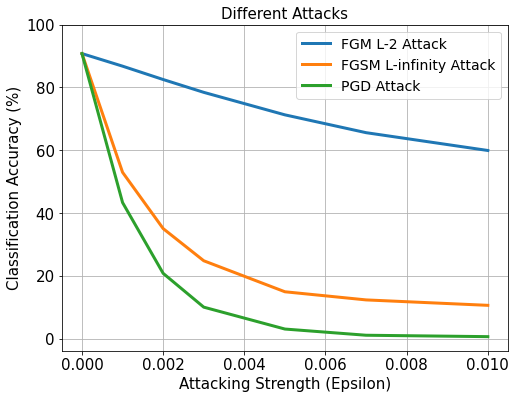

In [ ]:
figure, axis = plt.subplots()
arr_eps = np.array([0.000, 0.001, 0.002, 0.003, 0.005, 0.007, 0.010])
axis.plot(arr_eps, 100 * fgm_acc[0:7], label = "FGM L-2 Attack", linewidth = 3)
axis.plot(arr_eps, 100 * fgsm_acc[0:7], label = "FGSM L-infinity Attack", linewidth = 3)
# axis.plot(arr_eps, 100 * fgm_acc[0:7], label = "FGM L-2 Attack", linewidth = 3)
axis.plot(arr_eps, 100 * pgd_acc[0:7], label = "PGD Attack", linewidth = 3)
axis.set_xlabel("Attacking Strength (Epsilon)", fontsize = 15)
axis.set_ylabel("Classification Accuracy (%)", fontsize = 15)
axis.set_title("Different Attacks", fontsize = 15)
axis.grid()
figure.set_size_inches(8, 6)
xticks_eps = np.array([0.000, 0.002, 0.004, 0.006, 0.008, 0.010])
yticks_acc = np.linspace(0, 100, num = 6).astype(int)
plt.xticks(xticks_eps, fontsize = 15)
plt.yticks(yticks_acc, fontsize = 15)
plt.legend(loc = "upper right", fontsize = 14)
plt.show()

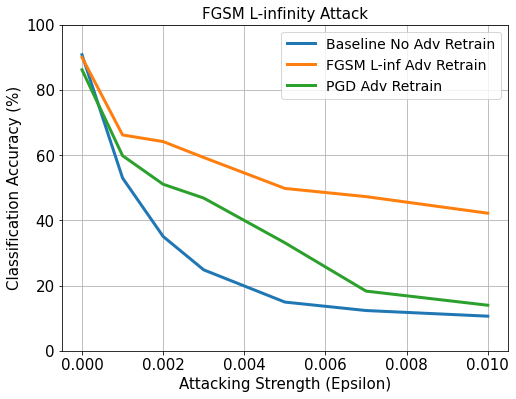

In [ ]:
figure, axis = plt.subplots()
arr_eps = np.array([0.000, 0.001, 0.002, 0.003, 0.005, 0.007, 0.010])
axis.plot(arr_eps, 100 * fgsm_acc[0:7], label = "Baseline No Adv Retrain", linewidth = 3)
axis.plot(arr_eps, 100 * fgsm_art_acc[0:7], label = "FGSM L-inf Adv Retrain", linewidth = 3)
axis.plot(arr_eps, 100 * pgd_art_fgsm_acc[0:7], label = "PGD Adv Retrain", linewidth = 3)
# axis.plot(arr_eps, 100 * pgd_AT_fgsm_acc[0:7], label = "PGD Adv Train", linewidth = 3)
axis.set_xlabel("Attacking Strength (Epsilon)", fontsize = 15)
axis.set_ylabel("Classification Accuracy (%)", fontsize = 15)
axis.set_title("FGSM L-infinity Attack", fontsize = 15)
axis.grid()
figure.set_size_inches(8, 6)
xticks_eps = np.array([0.000, 0.002, 0.004, 0.006, 0.008, 0.010])
yticks_acc = np.linspace(0, 100, num = 6).astype(int)
plt.xticks(xticks_eps, fontsize = 15)
plt.yticks(yticks_acc, fontsize = 15)
plt.legend(loc = "upper right", fontsize = 14)
plt.show()

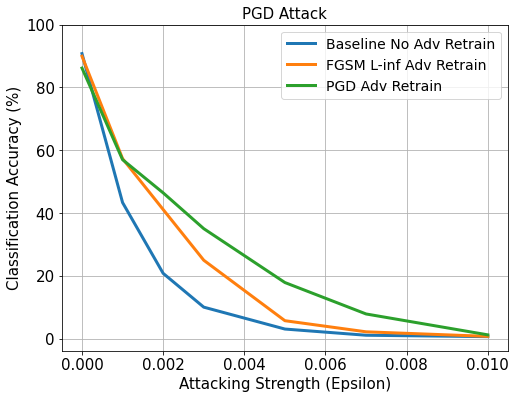

In [ ]:
figure, axis = plt.subplots()
arr_eps = np.array([0.000, 0.001, 0.002, 0.003, 0.005, 0.007, 0.010])
axis.plot(arr_eps, 100 * pgd_acc[0:7], label = "Baseline No Adv Retrain", linewidth = 3)
axis.plot(arr_eps, 100 * fgsm_art_pgd_acc[0:7], label = "FGSM L-inf Adv Retrain", linewidth = 3)
axis.plot(arr_eps, 100 * pgd_art_pgd_acc[0:7], label = "PGD Adv Retrain", linewidth = 3)
axis.set_xlabel("Attacking Strength (Epsilon)", fontsize = 15)
axis.set_ylabel("Classification Accuracy (%)", fontsize = 15)
axis.set_title("PGD Attack", fontsize = 15)
axis.grid()
figure.set_size_inches(8, 6)
xticks_eps = np.array([0.000, 0.002, 0.004, 0.006, 0.008, 0.010])
yticks_acc = np.linspace(0, 100, num = 6).astype(int)
plt.xticks(xticks_eps, fontsize = 15)
plt.yticks(yticks_acc, fontsize = 15)
plt.legend(loc = "upper right", fontsize = 14)
plt.show()

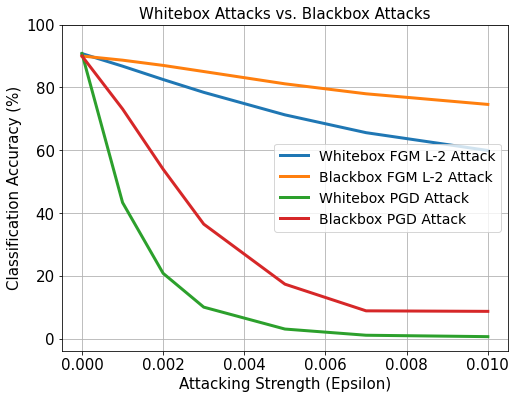

In [ ]:
figure, axis = plt.subplots()
arr_eps = np.array([0.000, 0.001, 0.002, 0.003, 0.005, 0.007, 0.010])
axis.plot(arr_eps, 100 * fgm_acc[0:7], label = "Whitebox FGM L-2 Attack", linewidth = 3)
axis.plot(arr_eps, 100 * blackbox_fgm_acc[0:7], label = "Blackbox FGM L-2 Attack", linewidth = 3)
axis.plot(arr_eps, 100 * pgd_acc[0:7], label = "Whitebox PGD Attack", linewidth = 3)
axis.plot(arr_eps, 100 * blackbox_pgd_acc[0:7], label = "Blackbox PGD Attack", linewidth = 3)
axis.set_xlabel("Attacking Strength (Epsilon)", fontsize = 15)
axis.set_ylabel("Classification Accuracy (%)", fontsize = 15)
axis.set_title("Whitebox Attacks vs. Blackbox Attacks", fontsize = 15)
axis.grid()
figure.set_size_inches(8, 6)
xticks_eps = np.array([0.000, 0.002, 0.004, 0.006, 0.008, 0.010])
yticks_acc = np.linspace(0, 100, num = 6).astype(int)
plt.xticks(xticks_eps, fontsize = 15)
plt.yticks(yticks_acc, fontsize = 15)
# plt.legend(loc = "upper right", fontsize = 14)
plt.legend(fontsize = 14)
plt.show()

### Interpret Re-validation results (Before Midterm)

In [ ]:
def plot_summary (base_acc, art_acc, detect_acc, eps_values, eps_values_T) :
    figure, axis = plt.subplots()
    # base_Spline = make_interp_spline(eps_values, base_acc)
    # art_Spline = make_interp_spline(eps_values, art_acc)
    detect_Spline = make_interp_spline(eps_values_T, detect_acc)
    # X0_ = np.linspace(eps_values.min(),eps_values.max(),20)
    X1_ = np.linspace(eps_values_T.min(),eps_values_T.max(),20)
    # base = base_Spline(X0_)
    # art = art_Spline(X0_)
    detect = detect_Spline(X1_)

    axis.plot(eps_values, base_acc,   label = "BASE", linewidth = 3)
    axis.plot(eps_values, art_acc,    label = "ART",  linewidth = 3)
    axis.plot(X1_, detect, label = "DECT", linewidth = 3)
    axis.set_xlabel("EPS", fontsize = 12)
    axis.set_ylabel("ACC", fontsize = 12)
    axis.set_title("No Subsampling", fontsize = 12)
    axis.grid()
    figure.set_size_inches(6, 4)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.legend(fontsize = 12)
    plt.show()
    return None

In [ ]:
eps_values_0 = np.array([0.000, 0.001, 0.002, 0.003, 0.005, 0.007, 
                       0.010, 0.020, 0.030])

fgsm_acc = np.array([0.90775833, 0.52973333, 0.35055833, 0.248125, 0.14935, 
                     0.12344167, 0.10616667, 0.08269167, 0.09775833])

fgsm_art_acc = np.array([0.89946667, 0.66180833, 0.64145833, 0.592725,   0.49783333, 0.47271667,
                        0.42183333, 0.127275, 0.08095])

eps_values_T0 = np.array([0, 0.001, 0.002, 0.003, 0.005, 0.007, 0.010, 0.012, 0.017, 0.022, 
                        0.027, 0.030])

detect0_acc = np.array([0, 0.007266666666666667, 0.012493333333333334, 0.03602, 0.2676733333333333, 
                       0.5352466666666666, 0.7463066666666667, 0.8421333333333333, 0.9984266666666667, 1.0, 1.0, 1.0])

eps_values_1 = np.array([0.00, 0.01, 0.02, 0.04, 0.06, 0.08, 0.10, 
                       0.20, 0.30, 0.40, 0.50])

fgm_acc = np.array([0.90775833, 0.59928333, 0.49648333, 0.28905833, 
                    0.22471667, 0.20176667, 0.19169167, 0.16296667, 0.13998333, 
                    0.12625833, 0.11841667])

fgm_art_acc = np.array([0.90353333, 0.71053333, 0.65710833, 0.601575,   0.57029167, 0.54256667,
                        0.51161667, 0.28706667, 0.16754167, 0.12459167, 0.11054167])

detect1_acc = np.array([0.007655555555555555, 0.026455555555555555, 0.21103333333333332, 0.4010888888888889, 0.5513888888888889, 
                        0.6603222222222223, 0.7446, 0.8098666666666666, 0.8561555555555556, 0.8914888888888889, 0.9173222222222223])

eps_values_T1 = np.array([0.00, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 
                       0.35, 0.4, 0.45, 0.50])



In [ ]:
eps_values_0 = np.array([0.000, 0.001, 0.002, 0.003, 0.005, 0.007, 
                       0.010, 0.020, 0.030])

fgsm_acc = np.array([0.88895833, 0.5662,     0.46883333, 0.36074167, 0.195175,   0.13670833,
                    0.12288333, 0.09525,    0.09901667])

fgsm_art_acc = np.array([0.873,      0.62846667, 0.550975,   0.4847,     0.37970833, 0.31566667,
                    0.27445833, 0.11316667, 0.09768333])

eps_values_T0 = np.array([0, 0.001, 0.002, 0.003, 0.005, 0.007, 0.010, 0.012, 0.017, 0.022, 
                        0.027, 0.030])

detect0_acc = np.array([0, 0.007266666666666667, 0.012493333333333334, 0.03602, 0.2676733333333333, 
                       0.5352466666666666, 0.7463066666666667, 0.8421333333333333, 0.9984266666666667, 1.0, 1.0, 1.0])

eps_values_1 = np.array([0.00, 0.01, 0.02, 0.04, 0.06, 0.08, 0.10, 
                       0.20, 0.30, 0.40, 0.50])

fgm_acc = np.array([0.88895833, 0.57163333, 0.41284167, 0.257725,   0.20806667, 0.17810833,
                    0.15861667, 0.12185,    0.11030833, 0.106225,   0.1036    ])

fgm_art_acc = np.array([0.873975,   0.67265,    0.60540833,  0.5442,     0.50801667, 0.47680833,
                        0.44433333, 0.28264167, 0.19341667, 0.164425,   0.15573333])

detect1_acc = np.array([0.007655555555555555, 0.026455555555555555, 0.21103333333333332, 0.4010888888888889, 0.5513888888888889, 
                        0.6603222222222223, 0.7446, 0.8098666666666666, 0.8561555555555556, 0.8914888888888889, 0.9173222222222223])

eps_values_T1 = np.array([0.00, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 
                       0.35, 0.4, 0.45, 0.50])

In [ ]:

plot_summary(fgsm_acc, fgsm_art_acc, detect0_acc, eps_values_0, eps_values_T0)

In [ ]:
plot_summary(fgm_acc, fgm_art_acc, detect1_acc, eps_values_1, eps_values_T1)

In [ ]:
#########################################################################

### Adversarial Retraining (Mitigation)

In [ ]:
model = CNN(input_size = 128)
# model.load_state_dict(torch.load("CNN_base_sub12.pt"))
# model.load_state_dict(torch.load("CNN_base.pt"))
model = model.to(device)
# model_checkpoint = "CNN_FGSM_ART_sub12.pt"
# model_checkpoint = "CNN_FGML2_ART_sub12.pt"
# model_checkpoint = "CNN_PGD_ART.pt"
model_checkpoint = "CNN_PGD_AdvTrain.pt"

num_epochs   = 20
best_val_acc = 0.
criterion    = nn.CrossEntropyLoss()
optimizer    = optim.Adam(model.parameters(), lr = 0.001)

for epoch in range(num_epochs) :
    model.train()
    train_epoch_loss = 0.
    train_epoch_acc  = 0.
    for batch_idx, (data, labels) in enumerate(TrainLoader) :
        data   = data.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()

        # #######################################################################
        # # PGD Adversarial Training
        # ATK_ITERS = 3 

        # adv_data = PGD_attack(model, device, data, labels, eps = 0.001, 
        #                       alpha = 0.5 * (0.001 / 3), iters = ATK_ITERS, rand_start = True)
        
        # outputs = model(adv_data)
        # loss = criterion(outputs, labels)
        # acc = evaluate_accuracy(outputs, labels)
        # #######################################################################

        #######################################################################
        # PGD Adversarial Retraining 
        ATK_ITERS = 3 
        adv1_data = PGD_attack(model, device, data, labels, eps = 0.001, 
                              alpha = 0.5 * (0.001 / 3), iters = ATK_ITERS, rand_start = True)
        adv2_data = PGD_attack(model, device, data, labels, eps = 0.002, 
                              alpha = 0.5 * (0.002 / 3), iters = ATK_ITERS, rand_start = True)
        adv3_data = PGD_attack(model, device, data, labels, eps = 0.003, 
                              alpha = 0.5 * (0.003 / 3), iters = ATK_ITERS, rand_start = True)
        adv4_data = PGD_attack(model, device, data, labels, eps = 0.005, 
                              alpha = 0.5 * (0.005 / 3), iters = ATK_ITERS, rand_start = True)
        # adv5_data = PGD_attack(model, device, data, labels, eps = 0.007, 
        #                       alpha = 0.5 * (0.007 / 3), iters = ATK_ITERS, rand_start = True)
        # adv6_data = PGD_attack(model, device, data, labels, eps = 0.010, 
        #                       alpha = 0.5 * (0.010 / 3), iters = ATK_ITERS, rand_start = True)
        
        adjdata = torch.vstack((data, adv1_data, adv2_data, adv3_data, adv4_data))
        adjlabels = torch.cat((labels, labels, labels, labels, labels))
        
        outputs = model(adjdata)
        loss = criterion(outputs, adjlabels)
        acc = evaluate_accuracy(outputs, adjlabels)
        #######################################################################
        
        # #######################################################################
        # # FGSM L-infinity Adversarial Retraining
        # adv1_data = FGSM_Linf_attack(model, device, data, labels, eps = 0.001)
        # adv2_data = FGSM_Linf_attack(model, device, data, labels, eps = 0.002)
        # adv3_data = FGSM_Linf_attack(model, device, data, labels, eps = 0.003)
        # adv4_data = FGSM_Linf_attack(model, device, data, labels, eps = 0.005)
        # adv5_data = FGSM_Linf_attack(model, device, data, labels, eps = 0.007)
        # adv6_data = FGSM_Linf_attack(model, device, data, labels, eps = 0.010)
        
        # adjdata = torch.vstack((adv1_data, adv2_data, adv3_data, 
        #                         adv4_data, adv5_data, adv6_data))
        # adjlabels = torch.cat((labels, labels, labels, 
        #                        labels, labels, labels))
        
        # outputs = model(adjdata)
        # loss = criterion(outputs, adjlabels)
        # acc = evaluate_accuracy(outputs, adjlabels)
        # #######################################################################
        
        # #######################################################################
        # # FGSM L-2 Adversarial Retraining
        # adv1_data = FGSM_L2_attack(model, device, data, labels, eps = 0.01)
        # adv2_data = FGSM_L2_attack(model, device, data, labels, eps = 0.02)
        # adv3_data = FGSM_L2_attack(model, device, data, labels, eps = 0.04)
        # adv4_data = FGSM_L2_attack(model, device, data, labels, eps = 0.06)
        # adv5_data = FGSM_L2_attack(model, device, data, labels, eps = 0.08)
        # adv6_data = FGSM_L2_attack(model, device, data, labels, eps = 0.10)
        
        # adjdata = torch.vstack((adv1_data, adv2_data, adv3_data, 
        #                         adv4_data, adv5_data, adv6_data))
        # adjlabels = torch.cat((labels, labels, labels, 
        #                        labels, labels, labels))
        
        # outputs = model(adjdata)
        # loss = criterion(outputs, adjlabels)
        # acc = evaluate_accuracy(outputs, adjlabels)
        # #######################################################################
        
        loss.backward()
        optimizer.step()
        
        train_epoch_loss += loss.item()
        train_epoch_acc  += acc.item()
    
    with torch.no_grad() :
        model.eval()
        val_epoch_loss = 0.
        val_epoch_acc  = 0.
        
        for X_val_batch, y_val_batch in TestLoader :
            X_val_batch = X_val_batch.to(device)
            y_val_batch = y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
            
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc  = evaluate_accuracy(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc  += val_acc.item()
    
    avg_train_loss = float(train_epoch_loss) / len(TrainLoader)
    avg_train_acc  = float(train_epoch_acc) / len(TrainLoader)
    avg_val_loss   = float(val_epoch_loss) / len(TestLoader)
    avg_val_acc    = float(val_epoch_acc) / len(TestLoader)
    
    print(f'Epoch {epoch+1}: | Train Acc: {avg_train_acc:.3f} | Test Acc: {avg_val_acc:.3f}')
    
    torch.save(model.state_dict(), model_checkpoint)
    print("Saving Model Checkpoint......")
    
    # if avg_val_acc > best_val_acc :
    #     print("Saving Model Checkpoint......")
    #     best_val_acc = avg_val_acc
    #     torch.save(model.state_dict(), model_checkpoint)

print("Adversarial Retraining Complete!")

### Autoencoder Training

In [ ]:
model = AUTOENCODER()
model.to(device)
model_checkpoint = "AUTOENCODER.pt"

num_epochs = 100
criterion  = nn.MSELoss()
optimizer  = optim.SGD(model.parameters(), lr = 0.001)
batch_size = 256

train_dataset = TensorDataset(x_train, x_train)
test_dataset  = TensorDataset(x_test,  x_test)

TrainLoader = DataLoader(train_dataset, batch_size = batch_size, 
                         shuffle = False)
TestLoader  = DataLoader(test_dataset,  batch_size = batch_size, 
                         shuffle = False)

best_val_loss = 1.

for epoch in range(num_epochs) :
    model.train()
    train_epoch_loss = 0.
    for batch_idx, (data, lbs) in enumerate(TrainLoader) :
        data   = data.to(device)
        lbs = lbs.to(device)
        
        optimizer.zero_grad()
        outputs = model(data)
        loss    = criterion(outputs, lbs)
        loss.backward()
        optimizer.step()
        
        train_epoch_loss += loss.item()
    
    with torch.no_grad() :
        model.eval()
        val_epoch_loss = 0.
        
        for X_val_batch, y_val_batch in TestLoader :
            X_val_batch = X_val_batch.to(device)
            y_val_batch = y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
            
            val_loss = criterion(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
    
    avg_train_loss = float(train_epoch_loss) / len(TrainLoader)
    avg_val_loss   = float(val_epoch_loss) / len(TestLoader)
    
    print(f'Epoch {epoch+1}: | Train Acc: {avg_train_loss:.4e} | Test Acc: {avg_val_loss:.4e}')
    
    if avg_val_loss < best_val_loss :
        print("Saving Model Checkpoint......")
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), model_checkpoint)

print("Training Complete!")

### Constructing AMC Adversarial Detector

In [ ]:
# EPS for FGSM attack
curr_attack = "FGSM_Linfinity"
eps_values = np.array([0.000, 0.001, 0.002, 0.003, 0.005, 0.007, 
                       0.010, 0.020, 0.030])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Current Device: ", device)
print(torch.cuda.get_device_name(torch.cuda.current_device()))

filename = "RML2016.10b.dat"
snrs, mods, X, labels = process_data(filename)

x_train, x_test, y_train, y_test, test_labels, test_idx = train_test_split(X, labels, mods)

train_dataset = TensorDataset(x_train, x_train)
test_dataset  = TensorDataset(x_test,  x_test)
batch_size = 16
TrainLoader = DataLoader(train_dataset, batch_size = batch_size, 
                         shuffle = False)
TestLoader  = DataLoader(test_dataset,  batch_size = batch_size, 
                         shuffle = False)

model = CNN(input_size = 128)
model.load_state_dict(torch.load("CNN_base.pt"))
model = model.to(device)
encoder = AUTOENCODER()
encoder.load_state_dict(torch.load("AUTOENCODER.pt"))
encoder.to(device)
criterion  = nn.MSELoss()

T = []
for eps in eps_values:
    E = []
    for batch_idx, (data, lbs) in enumerate(TrainLoader) :
        data = data.to(device)
        lbs = lbs.to(device)

        #FGSM L-infinity Adversarial Retraining
        adv_data = FGSM_Linf_attack(model, device, data, labels, eps)

        outputs = encoder(adv_data)
        loss = criterion(outputs,lbs)
        E.append(loss)
    
    T.append(max(E))

### Applying AMC Adversarial Detector

In [ ]:
encoder = AUTOENCODER()
encoder.load_state_dict(torch.load("AUTOENCODER.pt"))
encoder.to(device)

encoder.eval()

dtct_rate = []
for i in range(len(eps_values)) 
    detect_num = 0
    all_num = 0
    for X_val_batch, y_val_batch in TestLoader :
        X_val_batch = X_val_batch.to(device)
        y_val_batch = y_val_batch.to(device)
        
        adv_x = FGSM_Linf_attack(model, device, x_val_batch, y_val_batch, eps)
        y_val_pred = encoder(adv_x)
        val_loss = criterion(y_val_pred, adv_x)

        if val_loss > T:
            detect_num += 1
        all_num += 1
    
    detection_rate = float(detect_num) / float(all_num)  
    print(f'eps value {eps_values[i]}: Detection rate: {detection_rate:.3f}')   
    dtct_rate.append(detection_rate)

print(dict_rate)
